In [1]:
!pip install torch torchvision matplotlib


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)


In [4]:
train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())

test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 165kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.20MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.34MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Thêm định nghĩa batch_size ở đây
batch_size = 64

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


Train size: 54000
Validation size: 6000
Test size: 10000


In [7]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        # Khởi tạo trọng số và bias
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        out = self.output(x)
        return out


# Khởi tạo các tham số mô hình
input_dims = 784       # Input: 28x28 ảnh => 784 pixel
hidden_dims = 128      # Số node ẩn
output_dims = 10       # 10 nhãn tương ứng với Fashion MNIST
lr = 1e-2              # Learning rate

# Khởi tạo mô hình, hàm mất mát và optimizer
model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()  # Hàm mất mát CrossEntropyLoss
optimizer = optim.SGD(model.parameters(), lr=lr)  # Optimizer SGD với learning rate 0.01


In [8]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    # Chế độ huấn luyện
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    # Chế độ đánh giá
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    # In kết quả sau mỗi epoch
    print(f"EPOCH {epoch + 1}/{epochs}, "
          f"Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")


EPOCH 1/100, Train_Loss: 2.3018, Train_Acc: 0.1486, Validation Loss: 2.3012, Val_Acc: 0.0950
EPOCH 2/100, Train_Loss: 2.3002, Train_Acc: 0.1520, Validation Loss: 2.2991, Val_Acc: 0.2362
EPOCH 3/100, Train_Loss: 2.2957, Train_Acc: 0.2386, Validation Loss: 2.2902, Val_Acc: 0.3038
EPOCH 4/100, Train_Loss: 2.2204, Train_Acc: 0.2164, Validation Loss: 1.8571, Val_Acc: 0.1955
EPOCH 5/100, Train_Loss: 1.3774, Train_Acc: 0.4013, Validation Loss: 1.0707, Val_Acc: 0.5587
EPOCH 6/100, Train_Loss: 1.0633, Train_Acc: 0.5629, Validation Loss: 0.9878, Val_Acc: 0.6065
EPOCH 7/100, Train_Loss: 0.9525, Train_Acc: 0.6262, Validation Loss: 0.8651, Val_Acc: 0.6887
EPOCH 8/100, Train_Loss: 0.8709, Train_Acc: 0.6695, Validation Loss: 0.7910, Val_Acc: 0.7138
EPOCH 9/100, Train_Loss: 0.7975, Train_Acc: 0.7020, Validation Loss: 0.7337, Val_Acc: 0.7323
EPOCH 10/100, Train_Loss: 0.7259, Train_Acc: 0.7361, Validation Loss: 0.6707, Val_Acc: 0.7588
EPOCH 11/100, Train_Loss: 0.6526, Train_Acc: 0.7623, Validation Loss:

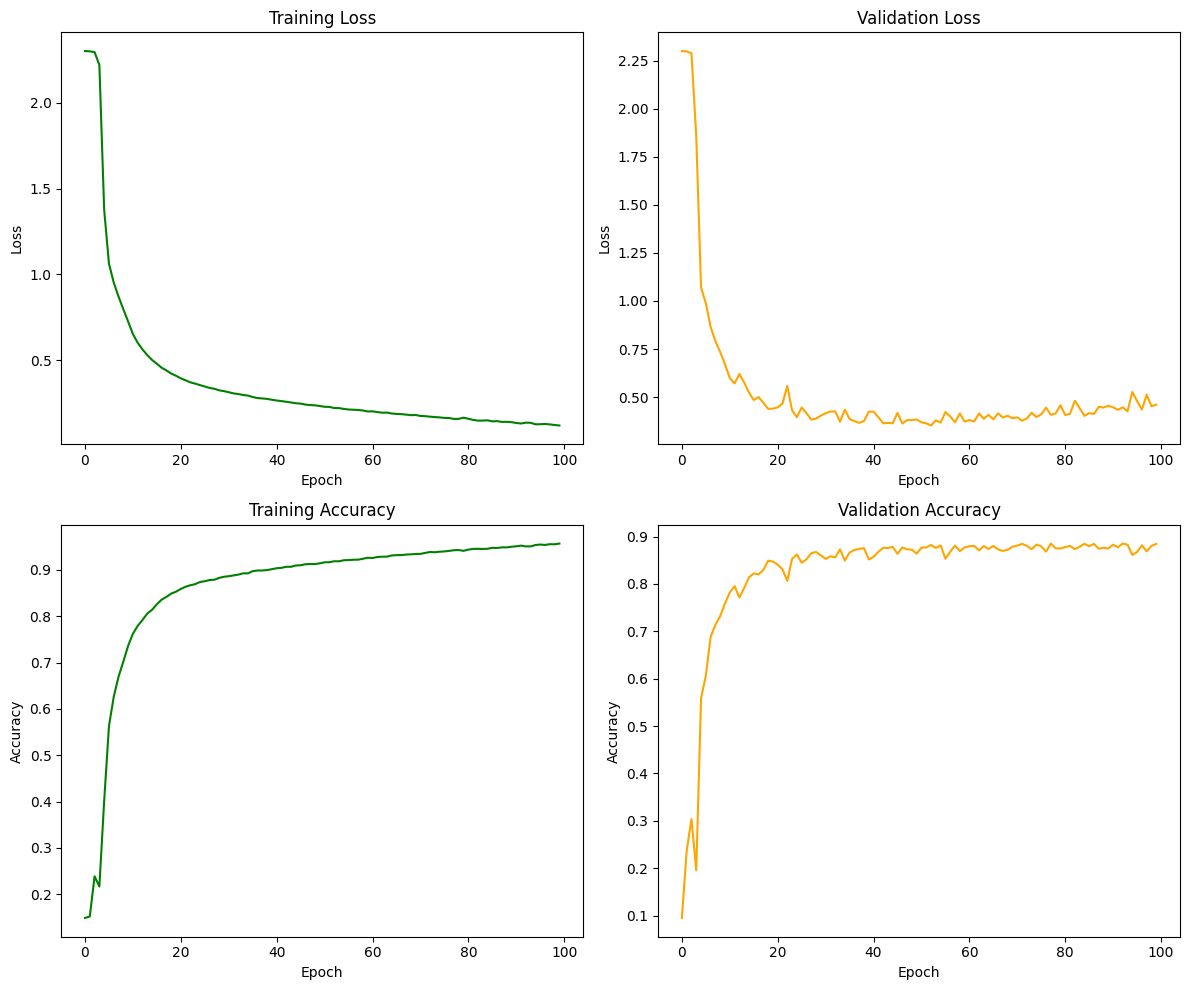

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Vẽ Training Loss
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Vẽ Validation Loss
ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Vẽ Training Accuracy
ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Vẽ Validation Accuracy
ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [10]:
test_target = []
test_predict = []

# Đặt mô hình ở chế độ đánh giá
model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)

        # Lưu lại dự đoán và nhãn thực tế
        test_predict.append(outputs.cpu())
        test_target.append(y_test.cpu())

# Ghép kết quả từ các batch thành một tensor duy nhất
test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)

# Tính toán độ chính xác
test_acc = (torch.argmax(test_predict, 1) == test_target).sum().item() / len(test_target)

# In kết quả
print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.4f}')


Evaluation on test set:
Accuracy: 0.8768
